# CIS 6800 Project: VAE and Diffusion Transformer

Instructions:

*  In this HW you will implement a patch-based VAE and train a Diffusion model using the pre-trained VAE checkpoint.
*  We provided you with a zipfile that contains a subset of 10,000 images from the CelebA dataset, along with an attribute file that includes binary labels for each image.
*  **Please submit your ipynb notebook as well as a pdf version of it. Include all visualizations and answers to the questions.**
*   Part A is due Wed 11/5, and Part B is due Wed 11/12.






Diffusion Transformer Paper: [https://arxiv.org/pdf/2212.09748](https://arxiv.org/pdf/2212.09748)


In [ ]:
# SSL Certificate Fix - Run this cell FIRST before any downloads
import os
import ssl
import certifi

# Set environment variables for SSL certificates
certifi_cert_path = certifi.where()
os.environ['SSL_CERT_FILE'] = certifi_cert_path
os.environ['REQUESTS_CA_BUNDLE'] = certifi_cert_path

# Patch SSL to use certifi certificates
import urllib.request
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi_cert_path)

# Patch HTTPSHandler
original_https_init = urllib.request.HTTPSHandler.__init__
def https_init_patched(self, debuglevel=0, context=None, check_hostname=None):
    if context is None:
        context = ssl.create_default_context(cafile=certifi_cert_path)
    return original_https_init(self, debuglevel=debuglevel, context=context, check_hostname=check_hostname)
urllib.request.HTTPSHandler.__init__ = https_init_patched

print("✓ SSL certificates configured using certifi")


In [1]:
!pip install -q torch torchvision numpy tqdm datasets torch-ema pytorch-lightning timm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [6]:
!pip install -q einops accelerate


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms as tf
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid, save_image
from torch_ema import ExponentialMovingAverage as EMA
import pytorch_lightning as pl

import math
import random
import numpy as np
from tqdm import tqdm
from einops import rearrange, repeat  # You can learn about einops at https://einops.rocks
from itertools import pairwise
from accelerate import Accelerator
from types import SimpleNamespace
from typing import Optional
import matplotlib.pyplot as plt
import torch.optim as optim

import zipfile
import io
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image, make_grid



/Users/kyle/Github/cis6800hw/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Set the seed for reproducibility

def set_seed(seed: int):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

# Part A

# Variational Autoencoder (VAE)


In this part of the project you will train a Patch-based VAE to capture key facial features on on a subset of the CelebA dataset, consisting of 10000 face images. You can use the code below to load images from the given zipfile. We recommend resizing the images to (32, 32) for the following tasks but you're welcome to experiment with different sizes.

In [9]:
class CelebADataset(Dataset):
    def __init__(self, zip_file, attr_file, selected_attrs=None, transform=None):
        self.zip_file = zip_file
        self.attr_file = attr_file
        self.transform = transform

        # Open the zip file and get the list of images
        self.attr_table, self.attr_names = self._load_attr_table(
            attr_file=self.attr_file,
            selected_attrs=selected_attrs
        )

        self.zip = zipfile.ZipFile(self.zip_file, 'r')
        self.image_list = [file for file in self.zip.namelist() if file.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # Get image name from the list
        path_in_zip = self.image_list[idx]
        basename = path_in_zip.split('/')[-1]
        try:
            # Read image data from the zip file
            with self.zip.open(path_in_zip) as f:
                img_bytes = f.read()
                img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
            if self.transform:
                img = self.transform(img)
            # Read annotations from the attr_file
            attrs = self.attr_table[basename]
        except zipfile.BadZipFile:
            return None
        except Exception:
            return None
        return img, attrs

    def _load_attr_table(self, attr_file, selected_attrs=None):
        with open(attr_file, "r") as f:
            lines = [line.rstrip("\n") for line in f if line.strip()]

        # Format: line0: count, line1: 40 names, then <fname> v1 ... v40
        all_attr_names = lines[1].split()
        name_to_idx = {n: i for i, n in enumerate(all_attr_names)}

        for a in selected_attrs:
            if a not in name_to_idx:
                raise ValueError(f"Attribute '{a}' not found in CelebA attributes.")

        sel_idx = [name_to_idx[a] for a in selected_attrs]

        table = {}
        for line in lines[2:]:
            parts = line.split()
            fname = parts[0]
            vals = np.array(list(map(int, parts[1:])), dtype=np.int16)
            sel  = vals[sel_idx]
            sel01 = ((sel + 1) // 2).astype(np.float32)
            table[fname] = torch.from_numpy(sel01)

        return table, selected_attrs

def collate_fn(batch):
    # Filter out None values (e.g., images that couldn't be loaded)
    batch = [b for b in batch if b is not None]
    # If the batch is empty after filtering, return None (can be skipped by DataLoader)
    if len(batch) == 0:
        return None

    return torch.utils.data.dataloader.default_collate(batch)

# Usage of the dataset and dataloader
def get_celeba_dataloader(zip_path, attr_file, batch_size=32, image_size=(32, 32), selected_attrs=None):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    train_dataset, valid_dataset = random_split(CelebADataset(zip_path, attr_file=attr_file, selected_attrs=selected_attrs, transform=transform), (0.8, 0.2))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
    return train_dataloader, valid_dataloader


# Function to display original and reconstructed images (4 images only)
def show_original_reconstructed(orig_images, recon_images, epoch):
    # Move the images back to CPU and denormalize
    orig_images = orig_images.cpu().numpy()
    recon_images = recon_images.cpu().numpy()

    # Clip the values to the valid range [0, 1] for display
    orig_images = np.clip(orig_images * 0.5 + 0.5, 0, 1)  # Denormalize and clip
    recon_images = np.clip(recon_images * 0.5 + 0.5, 0, 1)  # Denormalize and clip

    # Plot images side by side (4 images)
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))
    for i in range(4):
        # Original image
        axes[0, i].imshow(orig_images[i].transpose(1, 2, 0))  # Correct shape for imshow
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Reconstructed image
        axes[1, i].imshow(recon_images[i].transpose(1, 2, 0))  # Correct shape for imshow
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.suptitle(f'Epoch {epoch}: Original vs Reconstructed')
    plt.show()

In [11]:
#Initialize your dataloaders here
zip_file_path = "celeba_10000_images.zip"
attr_file_path = "list_attr_celeba.txt"
ATTR_ORDER = ["Male"]

train_dataloader, valid_dataloader = get_celeba_dataloader(zip_file_path, attr_file_path, batch_size=64, image_size=(32, 32), selected_attrs=ATTR_ORDER)

### Patch-based Variational Autoencoder

PatchVAE divides an input image into smaller patches and operates on these patches rather than the entire image at once. By processing images in patches, the PatchVAE learns to capture fine-grained (local) and high-level (global) patterns, depending on the patch size. In this section you should:

1.   Implement the PatchEmbed Class. This class is designed to create overlapping patches from an image, embed those patches into a latent space, and provide a method to reconstruct the image from the latent representations.

2.   Implement the PatchVAE model.

    *   The `encode` method convert patch embeddings into latent variables (mu and logvar) through a convolutional encoder. Rearrange patches to treat them as channels before passing them through the encoder.
    *   The `reparameterize` method applied the reparameterization trick `z = mu + eps * std` where `eps` is sampled from a standard normal distribution.
    *  The `decode` method convert the latent variable z back into patch embeddings, then reconstruct the original image from these patches
    *  The `forward` method first patchifies the image, encode, reparameterize, decode, and finally reconstruct the image
    *  The `compute_loss` calculates the reconstruction loss (Mean Squared Error) and the KL divergence loss to encourage the latent space to follow a normal distribution. Combine these losses to get the total VAE loss.
    *  The `sample` method generates new random images from the learned latent space. Random latent vector `z` are sampled, decoded into patches, and reconstructed into full images.


3.   Train the model on the faces dataset. **Experiment with different patch sizes and report the patch size with the best tradeoff between low-level details and high-level texture. Plot the training loss and visualize a couple reconstructed images during training.**

4. After training, generate sample images from the latent space. Specifically, you need to sample latent vectors from a normal distribution, decode the latent varaibles, and reconstruct the images. **Visualize 4 generated examples. Do the generated images resemble realistic human faces? Explain in a couple sentences.**

In [12]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=128, patch_size=32, stride=8, channels=3, embed_dim=128, bias=True):
        super().__init__()
        """
        Use Conv2D to create image patches of size (patch_size, patch_size) with overlapping regions.

        Each patch should have embedding size embed_dim.
        """
        self.patch_size = patch_size
        self.stride = stride
        self.embed_dim = embed_dim
        self.img_size = img_size

        # Conv2d to generate overlapping patches (from image to latent space)
        self.proj = nn.Conv2d(channels, embed_dim, kernel_size=patch_size, stride=stride, bias=bias)

        # Transposed Conv2d to reconstruct patches from latent space to RGB (from latent to image space)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 3, kernel_size=patch_size, stride=stride),
            nn.Tanh())
        H_out = (img_size - self.patch_size) // self.stride + 1
        W_out = (img_size - self.patch_size) // self.stride + 1
        self.num_patches = H_out * W_out

    def forward(self, x):
        """
        Input x is an image of size [B, C, img_size, img_size]

        Return patches of size [B, num_patches, embed_dim]
        """
        ######## BEGIN TODO ########
        # Apply convolution to create patches: [B, C, H, W] -> [B, embed_dim, H_out, W_out]
        x = self.proj(x)
        # Flatten spatial dimensions: [B, embed_dim, H_out, W_out] -> [B, embed_dim, num_patches]
        B, C, H, W = x.shape
        x = x.reshape(B, C, H * W)
        # Transpose: [B, embed_dim, num_patches] -> [B, num_patches, embed_dim]
        patches = x.transpose(1, 2)
        ######## END TODO ########

        return patches

    def reconstruct(self, patches, img_size):
        """
        Reconstruct the image from the patches by averaging overlapping regions.
        Input patches: [B, num_patches, embed_dim]
        img_size: (img_size, img_size)  # original size of the input image
        Output images: [B, img_size, img_size]
        """
        ######## BEGIN TODO ########
        # Reshape patches: [B, num_patches, embed_dim] -> [B, embed_dim, H_out, W_out]
        B, num_patches, embed_dim = patches.shape
        H_out = W_out = int(num_patches ** 0.5)
        patches = patches.transpose(1, 2).reshape(B, embed_dim, H_out, W_out)
        
        # Apply transposed convolution to reconstruct image
        reconstructed_image = self.deconv(patches)
        ######## END TODO ########

        return reconstructed_image

In [13]:
class PatchVAE(nn.Module):
    def __init__(self, patch_size, img_channels, img_size,
                  embed_dim=1024, latent_dim=512, stride=8):
        super(PatchVAE, self).__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.H_out = (self.img_size - self.patch_size) // stride + 1
        self.W_out = (self.img_size - self.patch_size) // stride + 1
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Patch embedding layer (Patchify the image)
        self.patch_embed = PatchEmbed(patch_size=patch_size, stride=stride, channels=img_channels, embed_dim=embed_dim)
        self.num_patches = self.patch_embed.num_patches

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(embed_dim, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.conv_mu = nn.Conv2d(128, latent_dim, kernel_size=3, stride=1, padding=1)
        self.conv_logvar = nn.Conv2d(128, latent_dim, kernel_size=3, stride=1, padding=1)

        # Decoder
        self.decoder_input = nn.Conv2d(latent_dim, 128, kernel_size=3, stride=1, padding=1)
        self.decoder = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, embed_dim, kernel_size=3, stride=1, padding=1),
        )

    def encode(self, patches):
        """
        Encode the patch embeddings into latent space (mu and logvar).
        Args:
            patches: Patch embeddings of shape [B, num_patches, embed_dim].
        """
        ######## BEGIN TODO ########
        # Rearrange patches to treat them as channels: [B, num_patches, embed_dim] -> [B, embed_dim, H_out, W_out]
        B = patches.shape[0]
        patches = patches.transpose(1, 2)  # [B, embed_dim, num_patches]
        patches = patches.reshape(B, self.embed_dim, self.H_out, self.W_out)
        
        # Pass through encoder
        x = self.encoder(patches)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        ######## END TODO ########
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) using N(0,1).
        Args:
            mu: Mean of the latent distribution.
            logvar: Log variance of the latent distribution.
        """
        ######## BEGIN TODO ########
        # std = torch.exp(0.5 * logvar)
        var = torch.clamp(logvar.exp(), min=1e-7, max=1e7)
        std = var.pow(0.5)
        eps = torch.randn_like(std)
        ######## END TODO ########
        return mu + eps * std

    def decode(self, z):
        """
        Decode the latent variable z back to patch embeddings.
        Args:
            z: Latent variable of shape [B, latent_dim, 1, num_patches].
        """
        ######## BEGIN TODO ########
        # Pass through decoder
        x = self.decoder_input(z)
        patch_recon = self.decoder(x)
        ######## END TODO ########
        return rearrange(patch_recon, 'b c h w -> b (h w) c')  # Back to (B, num_patches, embed_dim)

    def forward(self, x):
        """
        Forward pass through the VAE. Patchify the input, encode into latent space, reparameterize, and decode.
        Args:
            x: Input image of shape [B, C, img_size, img_size].
        """
        ######## BEGIN TODO ########
        # Patchify the input image
        patches = self.patch_embed(x)
        
        # Encode to latent space
        mu, logvar = self.encode(patches)
        
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        
        # Decode
        patch_recon = self.decode(z)
        
        # Reconstruct image from patches
        recon_image = self.patch_embed.reconstruct(patch_recon, self.img_size)
        ######## END TODO ########

        return recon_image, mu, logvar

    def compute_loss(self, recon_image, original_image, mu, logvar):
        """
        Compute the VAE loss, which consists of the reconstruction loss and KL divergence.
        Args:
            recon_image: Reconstructed image.
            original_image: Original input image.
            mu: Mean of the latent distribution.
            logvar: Log variance of the latent distribution.
        Returns:
            loss (Tensor): Total loss (reconstruction loss + KL divergence).
        """
        ######## BEGIN TODO ########
        # Reconstruction loss (Mean Squared Error)
        recon_loss = F.mse_loss(recon_image, original_image, reduction='sum') / original_image.size(0)        
        # KL divergence loss (mean over batch for stable scaling)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / mu.size(0)        ######## END TODO ########
        return recon_loss, kl_loss

    def sample(self, num_samples):
        """
        Generate random samples from the learned distribution.
        Args:
            num_samples (int): Number of samples to generate.
        Returns:
            samples (Tensor): Generated
        """
        ######## BEGIN TODO ########
        # Sample random latent vectors from standard normal distribution
        z = torch.randn(num_samples, self.latent_dim, self.H_out, self.W_out).to(self.device)
        
        # Decode the latent vectors to patch embeddings
        with torch.no_grad():
            patch_samples = self.decode(z)
            
            # Reconstruct images from patches
            sample_images = self.patch_embed.reconstruct(patch_samples, self.img_size)
        ######## END TODO ########
        return sample_images

In [14]:
def train_patchvae(model, train_dataloader, valid_dataloader, optimizer, device, epochs=10, print_interval=100, checkpoint_path='best_model.pth'):
    """
    Training loop for the PatchVAE model with visualization of reconstructed images and saving the best model checkpoint.

    Args:
        model: The PatchVAE model to be trained.
        dataloader: Dataloader for the training data.
        optimizer: Optimizer for updating the model parameters.
        device: Device (CPU or GPU) on which the training will run.
        epochs: Number of training epochs.
        print_interval: Interval at which the loss will be printed during training.
        checkpoint_path: Path to save the best model checkpoint.

    Returns:
        losses: List of training losses for each epoch.
    """
    model.train()
    model.to(device)
    losses = []
    best_loss = float('inf')  # Initialize with a large value
    initial_beta = 0.0005  # Start with a small KL weight
    final_beta = 1.0    # Gradually increase to full KL weight

    for epoch, beta in zip(range(epochs), torch.linspace(initial_beta, final_beta, epochs)):
        for batch in train_dataloader:
            if batch is None:
                continue
            else:
                ims, _ = batch
    ######## BEGIN TODO ########
                ims = ims.to(device)
                optimizer.zero_grad()
                
                # Forward pass
                recon_image, mu, logvar = model(ims)
                
                # Compute loss
                recon_loss, kl_loss = model.compute_loss(recon_image, ims, mu, logvar)
                loss = recon_loss + beta * kl_loss
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                losses.append(loss.item())
        
        # Validation and visualization every epoch
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                for batch in valid_dataloader:
                    if batch is None:
                        continue
                    val_ims, _ = batch
                    val_ims = val_ims.to(device)
                    recon_images, _, _ = model(val_ims)
                    
                    # Denormalize for visualization
                    original_vis = (val_ims * 0.5 + 0.5).clamp(0, 1)
                    recon_vis = (recon_images * 0.5 + 0.5).clamp(0, 1)
                    
                    visualize_reconstruction(original_vis[:4], recon_vis[:4], epoch)
                    break
            model.train()
        
        # Save best model
        avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f} - Model saved!')
        else:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    ######## END TODO ########
    return losses

def visualize_reconstruction(original_images, recon_images, epoch):
    """
    Visualize original and reconstructed images side by side.

    Args:
        original_images: Batch of original images (values between 0 and 1).
        recon_images: Batch of reconstructed images (values between 0 and 1).
        epoch: Current epoch number.
    """
    num_images = min(4, original_images.size(0))  # Visualize at most 4 images
    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))

    for i in range(num_images):
        # Original images (ensure values are between 0 and 1)
        orig_img = original_images[i].permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
        orig_img = np.clip(orig_img, 0, 1)  # Clip values to [0, 1] range

        # Reconstructed images (ensure values are between 0 and 1)
        recon_img = recon_images[i].permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
        recon_img = np.clip(recon_img, 0, 1)  # Clip values to [0, 1] range

        # Display original images
        axes[0, i].imshow(orig_img)
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Display reconstructed images
        axes[1, i].imshow(recon_img)
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.suptitle(f"Reconstruction at Epoch {epoch+1}")
    plt.show()



Epoch [1/90], Loss: 527.6449 - Model saved!
Epoch [2/90], Loss: 278.7294 - Model saved!
Epoch [3/90], Loss: 234.4016 - Model saved!
Epoch [4/90], Loss: 212.5898 - Model saved!
Epoch [5/90], Loss: 200.0718 - Model saved!
Epoch [6/90], Loss: 194.3278 - Model saved!
Epoch [7/90], Loss: 190.1264 - Model saved!
Epoch [8/90], Loss: 187.0171 - Model saved!
Epoch [9/90], Loss: 184.9259 - Model saved!


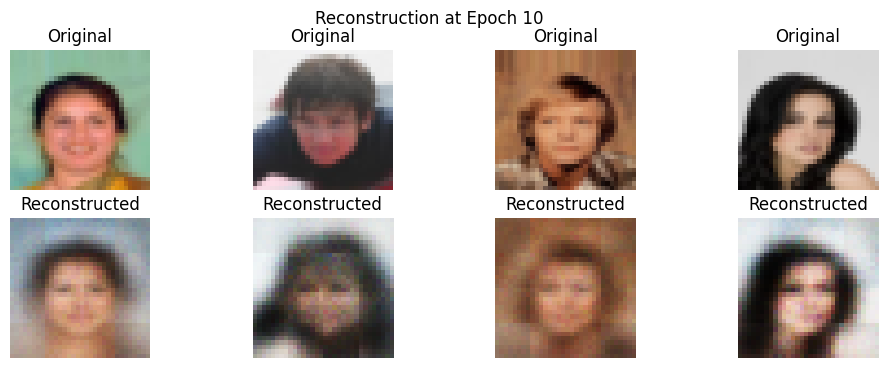

Epoch [10/90], Loss: 183.6334 - Model saved!
Epoch [11/90], Loss: 182.7150 - Model saved!
Epoch [12/90], Loss: 182.8204
Epoch [13/90], Loss: 181.9993 - Model saved!
Epoch [14/90], Loss: 181.3302 - Model saved!
Epoch [15/90], Loss: 181.5191
Epoch [16/90], Loss: 181.5452
Epoch [17/90], Loss: 181.1045 - Model saved!
Epoch [18/90], Loss: 180.1924 - Model saved!
Epoch [19/90], Loss: 179.8381 - Model saved!


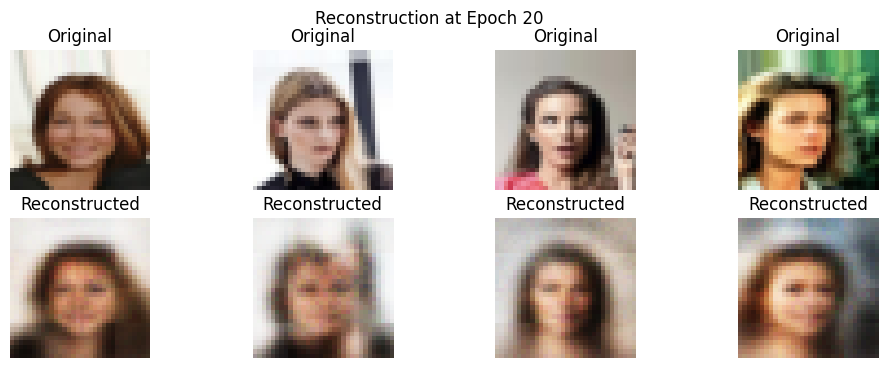

Epoch [20/90], Loss: 179.8107 - Model saved!
Epoch [21/90], Loss: 179.1303 - Model saved!
Epoch [22/90], Loss: 178.9710 - Model saved!
Epoch [23/90], Loss: 178.1645 - Model saved!
Epoch [24/90], Loss: 178.0104 - Model saved!
Epoch [25/90], Loss: 177.3959 - Model saved!
Epoch [26/90], Loss: 176.8682 - Model saved!
Epoch [27/90], Loss: 176.5216 - Model saved!
Epoch [28/90], Loss: 176.1135 - Model saved!
Epoch [29/90], Loss: 175.7463 - Model saved!


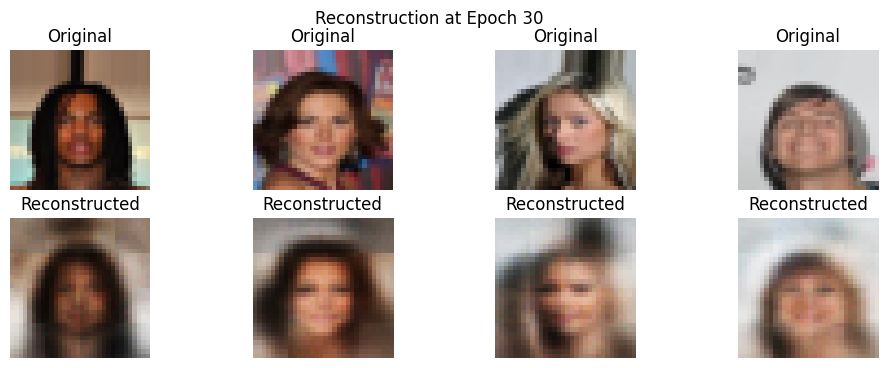

Epoch [30/90], Loss: 175.0720 - Model saved!
Epoch [31/90], Loss: 174.9648 - Model saved!
Epoch [32/90], Loss: 174.7381 - Model saved!
Epoch [33/90], Loss: 174.0401 - Model saved!
Epoch [34/90], Loss: 173.7330 - Model saved!
Epoch [35/90], Loss: 173.3854 - Model saved!
Epoch [36/90], Loss: 173.1627 - Model saved!
Epoch [37/90], Loss: 172.9004 - Model saved!
Epoch [38/90], Loss: 173.0407
Epoch [39/90], Loss: 172.5311 - Model saved!


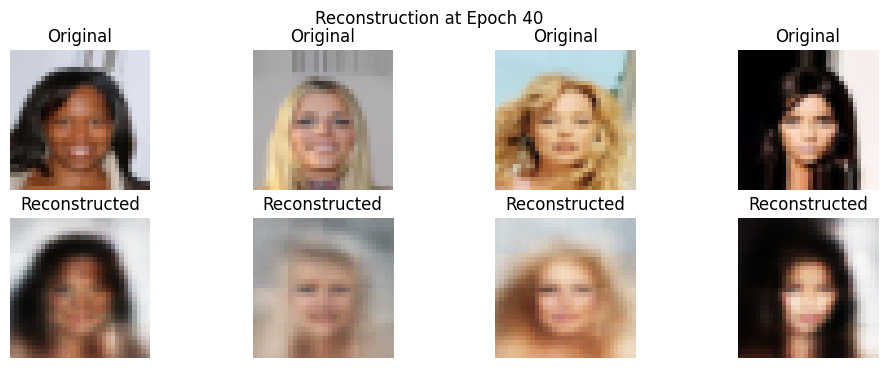

Epoch [40/90], Loss: 172.8841
Epoch [41/90], Loss: 172.3497 - Model saved!
Epoch [42/90], Loss: 172.4626
Epoch [43/90], Loss: 172.4913
Epoch [44/90], Loss: 172.2100 - Model saved!
Epoch [45/90], Loss: 172.5458
Epoch [46/90], Loss: 172.3682
Epoch [47/90], Loss: 172.5571
Epoch [48/90], Loss: 172.8453
Epoch [49/90], Loss: 172.6424


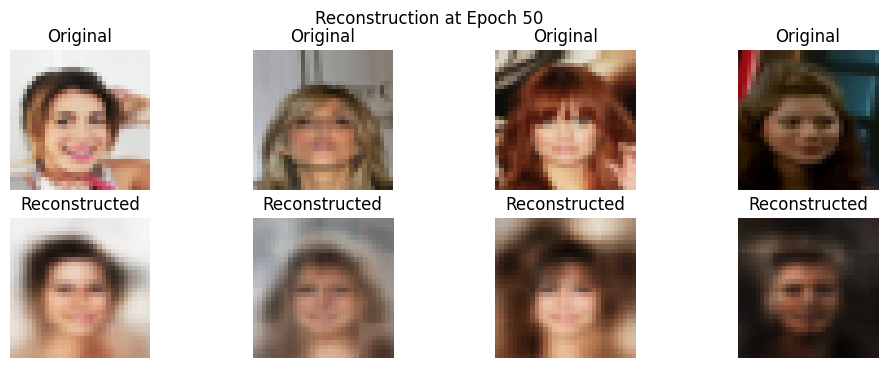

Epoch [50/90], Loss: 172.9656
Epoch [51/90], Loss: 172.9373
Epoch [52/90], Loss: 173.3699
Epoch [53/90], Loss: 173.3512
Epoch [54/90], Loss: 173.5395
Epoch [55/90], Loss: 173.5778
Epoch [56/90], Loss: 174.0310
Epoch [57/90], Loss: 174.2241
Epoch [58/90], Loss: 174.3398
Epoch [59/90], Loss: 174.7372


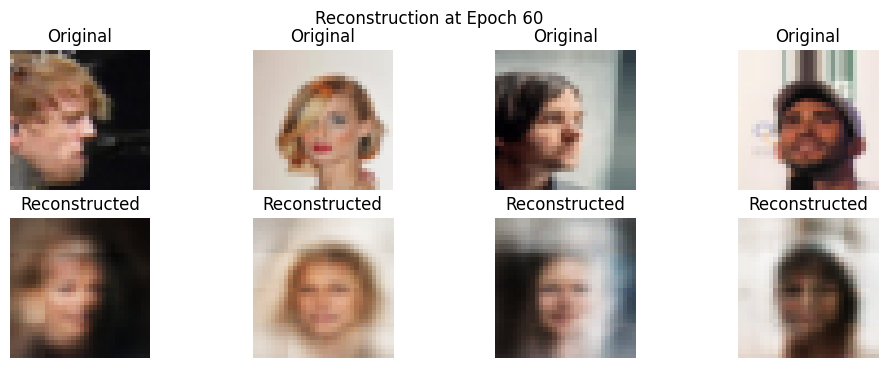

Epoch [60/90], Loss: 174.6104
Epoch [61/90], Loss: 175.0844
Epoch [62/90], Loss: 175.5206
Epoch [63/90], Loss: 175.8021
Epoch [64/90], Loss: 176.4227
Epoch [65/90], Loss: 176.5546
Epoch [66/90], Loss: 176.5889
Epoch [67/90], Loss: 177.4112
Epoch [68/90], Loss: 177.5971
Epoch [69/90], Loss: 177.8597


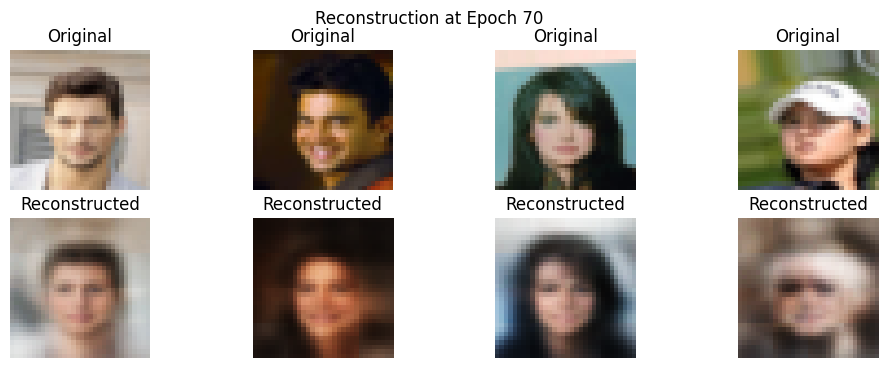

Epoch [70/90], Loss: 178.3041
Epoch [71/90], Loss: 178.6438
Epoch [72/90], Loss: 179.0670
Epoch [73/90], Loss: 179.4623
Epoch [74/90], Loss: 179.7102
Epoch [75/90], Loss: 180.1046
Epoch [76/90], Loss: 180.6301
Epoch [77/90], Loss: 180.9260
Epoch [78/90], Loss: 181.2870
Epoch [79/90], Loss: 182.0522


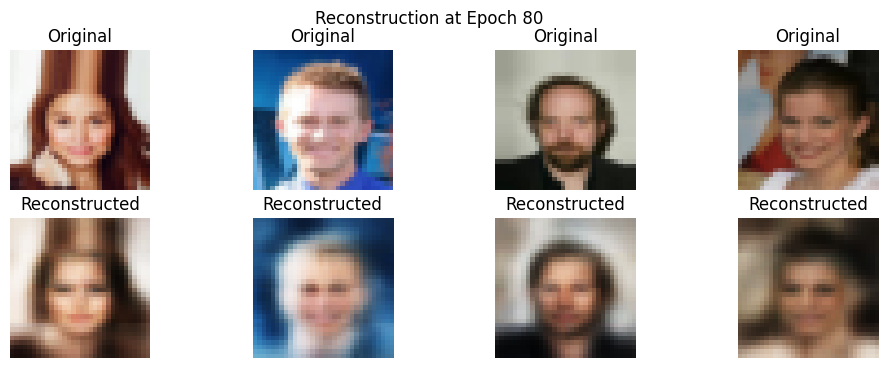

Epoch [80/90], Loss: 182.1499
Epoch [81/90], Loss: 182.5581
Epoch [82/90], Loss: 182.9203
Epoch [83/90], Loss: 183.3044
Epoch [84/90], Loss: 183.8515
Epoch [85/90], Loss: 184.2482
Epoch [86/90], Loss: 184.5194
Epoch [87/90], Loss: 185.0173
Epoch [88/90], Loss: 185.3936
Epoch [89/90], Loss: 186.0662


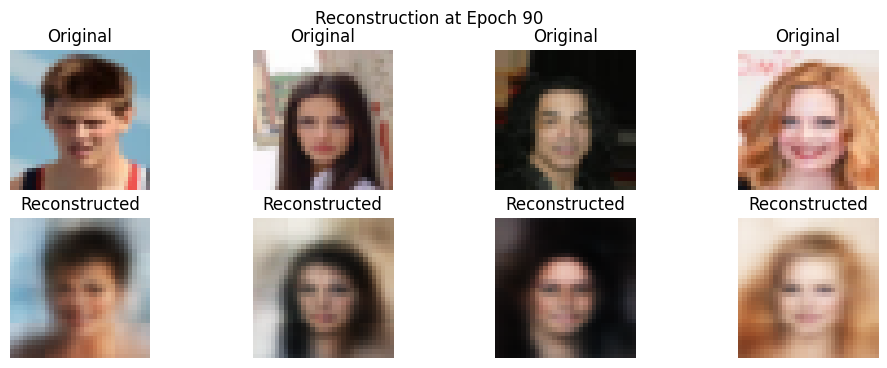

Epoch [90/90], Loss: 186.5173


[1133.650390625,
 1155.3736572265625,
 1173.932373046875,
 1038.2459716796875,
 1072.33447265625,
 1038.7608642578125,
 1049.6290283203125,
 1081.3804931640625,
 990.4814453125,
 954.2736206054688,
 971.1903686523438,
 920.0369873046875,
 929.1851196289062,
 962.034912109375,
 944.8412475585938,
 947.7116088867188,
 830.2372436523438,
 779.7788696289062,
 810.6831665039062,
 812.97509765625,
 778.701171875,
 783.2407836914062,
 795.9003295898438,
 739.8968505859375,
 720.2280883789062,
 695.8548583984375,
 712.9010009765625,
 688.096923828125,
 634.2800903320312,
 668.2211303710938,
 627.83740234375,
 593.449462890625,
 666.11767578125,
 545.5737915039062,
 567.7130126953125,
 597.7902221679688,
 596.4161987304688,
 517.85791015625,
 594.6903076171875,
 557.282470703125,
 522.1975708007812,
 560.6126098632812,
 499.7656555175781,
 532.93310546875,
 489.42364501953125,
 508.33294677734375,
 464.29071044921875,
 509.552490234375,
 492.6618957519531,
 485.2449645996094,
 473.5769653320312

In [15]:
# Train PatchVAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resume_training = False
checkpoint_path = 'best_vae_model.pth'


vae = PatchVAE(patch_size=16, img_channels=3, img_size=32, embed_dim=64, latent_dim=128).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-4, betas=(0.5, 0.999))

if resume_training:
    vae.load_state_dict(torch.load(checkpoint_path))

train_patchvae(vae, train_dataloader, valid_dataloader, optimizer, device, epochs=90, checkpoint_path=checkpoint_path)

samples min: 0.067664325
samples max: 0.96911013


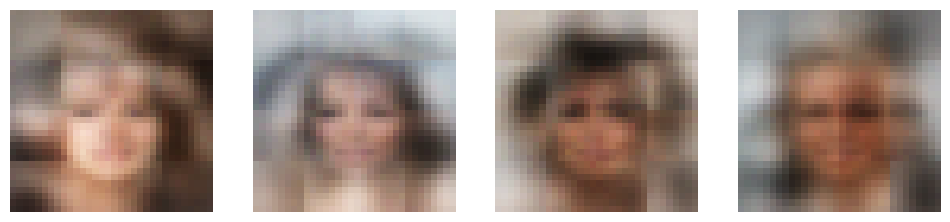

In [16]:
# Generate images by sampling from latent space
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = 'best_vae_model.pth'
vae = PatchVAE(patch_size=16, img_channels=3, img_size=32, embed_dim=64, latent_dim=128).to(device)
vae.load_state_dict(torch.load(checkpoint_path))
vae.eval()

samples = 0.5 + 0.5 * vae.sample(4)
samples = samples.permute(0, 2, 3, 1).cpu().numpy()
print("samples min:", np.min(samples))
print("samples max:", np.max(samples))

samples = np.clip(samples, 0, 1)
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(samples[i])
    axes[i].axis('off')

# Part B

# Diffusion Transformer (DiT)


We will train a DiT that operates in the patch latent space on the same dataset. The input image is decomposed into patches and processed by several DiT blocks.

### Implement Noise Scheduler


You will implement parts of the [DDPM scheduler](https://huggingface.co/docs/diffusers/en/api/schedulers/ddpm) using the following steps.

1. Define $\beta$ as a tensor of $N$ linearly spaced values between $\beta_{start}$ and $\beta_{end}$.

$$\beta = \left[\beta_{\text{start}}, \beta_{\text{start}} + \frac{\beta_{\text{end}} - \beta_{\text{start}}}{N - 1}, \ldots, \beta_{\text{end}}\right]$$

2. Calculate $\sigma$ using the cumulative product of $1 - \beta$.

$$\sigma = \sqrt{\frac{1}{\prod_{i=0}^{N-1}(1 - \beta_i)} - 1}$$

In [17]:
class DDPMScheduler:
    def __init__(self, N: int=1000, beta_start: float=0.0001, beta_end: float=0.02):
        ######## BEGIN TODO ########
        # Define beta as linearly spaced values
        beta = torch.linspace(beta_start, beta_end, N)
        
        # Calculate alpha = 1 - beta
        alpha = 1 - beta
        
        # Calculate cumulative product of alpha
        alpha_cumprod = torch.cumprod(alpha, dim=0)
        
        # Calculate sigma = sqrt(1/alpha_cumprod - 1)
        self.sigmas = torch.sqrt(1.0 / alpha_cumprod - 1)
        ######## END TODO ########
        
    def __getitem__(self, i) -> torch.FloatTensor:
        return self.sigmas[i]

    def __len__(self) -> int:
        return len(self.sigmas)

    def sample_sigmas(self, steps: int) -> torch.FloatTensor:
        indices = list((len(self) * (1 - np.arange(0, steps)/steps)).round().astype(np.int64) - 1)
        return self[indices + [0]]

    def sample_batch(self, x0: torch.FloatTensor) -> torch.FloatTensor:
        batchsize = x0.shape[0]
        return self[torch.randint(len(self), (batchsize,))].to(x0)

### Implement DiT Block

You will implement the DiT Block with adaLN-Zero, as illustrated in Figure 3 of the Diffusion Transformer paper. Specifically, you will need to implement Multi-Head Self-Attention, Modulation, and Adaptive Layer Norm for the DiT Block, and we will provide you with the code structure.

In [18]:
class Attention(nn.Module):
    def __init__(self, head_dim, num_heads=8, qkv_bias=False):
        super().__init__()
        """
        Inputs:
            head_dim (int): Dimensionality of each attention head
            num_heads (int): Number of attention heads
            qkv_bias (bool): Whether to include bias in the QKV layer
        """
        self.num_heads = num_heads
        self.head_dim = head_dim
        dim = head_dim * num_heads

        ######## BEGIN TODO ########
        # Linear layer to generate query, key, value (3 * dim for Q, K, V)
        self.qkv = nn.Linear(dim, 3 * dim, bias=qkv_bias)
        # Output projection layer
        self.proj = nn.Linear(dim, dim)
        ######## END TODO #######


    def forward(self, x):
        """
        Inputs:
            x (Tensor): Input tensor of shape (B, N, D), where:
                - B: Batch size
                - N: Number of tokens
                - D: Dimensionality (D = num_heads * head_dim)

        Returns:
            Output tensor of shape (B, N, D) after applying attention and projection

        You may use F.scaled_dot_product_attention
        """
        # (B, N, D) -> (B, N, D)
        # N = H * W / patch_size**2, D = num_heads * head_dim

        ######## BEGIN TODO ########
        B, N, D = x.shape
        
        # Generate Q, K, V from input: (B, N, D) -> (B, N, 3*D) -> (B, N, 3, num_heads, head_dim)
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        # Permute to (3, B, num_heads, N, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each: (B, num_heads, N, head_dim)
        
        # Apply scaled dot-product attention
        attn_output = F.scaled_dot_product_attention(q, k, v)  # (B, num_heads, N, head_dim)
        
        # Reshape back: (B, num_heads, N, head_dim) -> (B, N, num_heads, head_dim) -> (B, N, D)
        attn_output = attn_output.transpose(1, 2).reshape(B, N, D)
        
        # Apply output projection
        output = self.proj(attn_output)
        
        return output
        ######## END TODO #######

In [19]:
class Modulation(nn.Module):
    def __init__(self, dim, n):
        super().__init__()
        """
        1. self.proj is constructed as a sequence of operations:
            - A SiLU (Sigmoid-Weighted Linear Unit) activation is applied to the input
            - A linear layer transforms the input from dim to n * dim
        2. The last layer's weights and biases are initialized to zero
        """
        ######## BEGIN TODO ########
        self.n = n
        self.proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(dim, n * dim)
        )
        # Initialize the last layer to zero
        nn.init.constant_(self.proj[1].weight, 0)
        nn.init.constant_(self.proj[1].bias, 0)
        ######## END TODO #######


    def forward(self, y):
        """
        1. self.proj(y) applies the defined projection, resulting in n * dim
        2. Split the output tensor into n equal parts along dimension 1
        3. Each chunk `m` has the shape dim and represents a separate modulation component
        4. m.unsqueeze(1) adds a new dimension at index 1, necessary for future computations
        """
        ######## BEGIN TODO ########
        # Apply projection: (B, dim) -> (B, n * dim)
        projected = self.proj(y)
        
        # Split into n chunks along dimension 1: (B, n * dim) -> n tensors of (B, dim)
        chunks = torch.chunk(projected, self.n, dim=1)
        
        # Add dimension at index 1 for broadcasting: (B, dim) -> (B, 1, dim)
        return tuple(m.unsqueeze(1) for m in chunks)
        ######## END TODO #######


class AdaptiveLayerNorm(nn.LayerNorm):
    def __init__(self, dim, **kwargs):
        super().__init__(dim, **kwargs)
        """
        Initialize an instance of Modulation with dim and n = 2
        """
        ######## BEGIN TODO ########
        self.modulation = Modulation(dim, 2)
        ######## END TODO #######


    def forward(self, x, y):
        """
        1. Obtain (scale, shift) tensors from applying modulation on input y
        2. Apply LayerNorm on input x, which we will denote as LayerNorm(x)
        3. Compute AdaptiveLayerNorm as `LayerNorm(x) * (1 + scale) + shift`
        """
        ######## BEGIN TODO ########
        # Get scale and shift from modulation
        scale, shift = self.modulation(y)
        
        # Apply LayerNorm
        normalized = super().forward(x)
        
        # Apply adaptive scaling and shifting
        return normalized * (1 + scale) + shift
        ######## END TODO #######

In [20]:
class DiTBlock(nn.Module):
    def __init__(self, head_dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        dim = head_dim * num_heads
        mlp_hidden_dim = int(dim * mlp_ratio)

        self.norm1 = AdaptiveLayerNorm(dim, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(head_dim, num_heads=num_heads, qkv_bias=True)
        self.norm2 = AdaptiveLayerNorm(dim, elementwise_affine=False, eps=1e-6)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim, bias=True),
            nn.GELU(approximate="tanh"),
            nn.Linear(mlp_hidden_dim, dim, bias=True),
        )
        self.scale_modulation = Modulation(dim, 2)

    def forward(self, x, y):
        # (B, N, D), (B, D) -> (B, N, D)
        # N = H * W / patch_size**2, D = num_heads * head_dim
        gate_msa, gate_mlp = self.scale_modulation(y)
        x = x + gate_msa * self.attn(self.norm1(x, y))
        x = x + gate_mlp * self.mlp(self.norm2(x, y))
        return x

In [21]:
def sigma_log_scale(batches, sigma, scaling_factor):
    # Handle scalar sigma
    if sigma.shape == torch.Size([]):
        sigma = sigma.unsqueeze(0).repeat(batches)
    # Handle 1D sigma with wrong batch size or need reshaping
    elif len(sigma.shape) == 1:
        if sigma.shape[0] != batches:
            # If sigma has only 1 element, repeat it
            if sigma.shape[0] == 1:
                sigma = sigma.repeat(batches)
            else:
                raise ValueError(f'sigma shape {sigma.shape} does not match batch size {batches}')
    else:
        raise ValueError(f'sigma must be scalar or 1D, got shape {sigma.shape}')
    return torch.log(sigma)*scaling_factor


def get_sigma_embeds(batches, sigma, scaling_factor=0.5):
    s = sigma_log_scale(batches, sigma, scaling_factor).unsqueeze(1)
    return torch.cat([torch.sin(s), torch.cos(s)], dim=1)


class SigmaEmbedderSinCos(nn.Module):
    def __init__(self, hidden_size, scaling_factor=0.5):
        super().__init__()
        ######## BEGIN TODO ########
        self.scaling_factor = scaling_factor
        # MLP to embed the sigma values
        # Input: 2 (sin and cos), Output: hidden_size
        self.mlp = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        ######## END TODO #######


    def forward(self, batches, sigma):
        """

        """
        ######## BEGIN TODO ########
        # Get sin/cos embeddings of sigma
        sigma_embeds = get_sigma_embeds(batches, sigma, self.scaling_factor)
        
        # Pass through MLP
        return self.mlp(sigma_embeds)
        ######## END TODO #######

### Helper Functions

We provide you with the following helper functions for training DiT. No implementation needed.

In [22]:
def get_pos_embed(in_dim, patch_size, dim, N=10000):
    n = in_dim // patch_size                                          # Number of patches per side
    assert dim % 4 == 0, 'Embedding dimension must be multiple of 4!'
    omega = 1 / N ** np.linspace(0, 1, dim // 4, endpoint=False)      # [dim/4]
    freqs = np.outer(np.arange(n), omega)                             # [n, dim/4]
    embeds = repeat(np.stack([np.sin(freqs), np.cos(freqs)]),
                       ' b n d -> b n k d', k=n)                      # [2, n, n, dim/4]
    embeds_2d = np.concatenate([
        rearrange(embeds, 'b n k d -> (k n) (b d)'),                  # [n*n, dim/2]
        rearrange(embeds, 'b n k d -> (n k) (b d)'),                  # [n*n, dim/2]
    ], axis=1)                                                        # [n*n, dim]
    return nn.Parameter(torch.tensor(embeds_2d).float().unsqueeze(0), # [1, n*n, dim]
                        requires_grad=False)

In [23]:
class ModelMixin:
    def rand_input(self, batchsize):
        assert hasattr(self, 'input_dims'), 'Model must have "input_dims" attribute!'
        return torch.randn((batchsize,) + self.input_dims)

    # Currently predicts eps, override following methods to predict, for example, x0
    def get_loss(self, x0, sigma, eps):
        # Ensure sigma is properly shaped for broadcasting
        # sigma should be (B,), reshape to (B, 1, 1, 1) for broadcasting with (B, C, H, W)
        sigma_reshaped = sigma.view(-1, 1, 1, 1)
        noisy_x = x0 + sigma_reshaped * eps
        eps_pred = self(noisy_x, sigma)
        return nn.MSELoss()(eps, eps_pred)

    def predict_eps(self, x, sigma):
        return self(x, sigma)

### Implement Entire DiT Model

In [24]:
class DiT(nn.Module, ModelMixin):
    def __init__(self, in_dim, channels, patch_size, depth,
                 head_dim, num_heads, mlp_ratio, sig_embed_factor,
                 sig_embed_class=None):
        super().__init__()

        self.in_dim = in_dim
        self.channels = channels
        self.patch_size = patch_size
        self.input_dims = (channels, in_dim, in_dim)

        dim = head_dim * num_heads

        self.pos_embed = get_pos_embed(in_dim, patch_size, dim)
        self.sig_embed = (sig_embed_class or SigmaEmbedderSinCos)(
            dim, scaling_factor=sig_embed_factor
        )

        self.blocks = nn.ModuleList([
            DiTBlock(head_dim, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])

        self.final_norm = AdaptiveLayerNorm(dim, elementwise_affine=False, eps=1e-6)
        self.final_linear = nn.Linear(dim, patch_size**2 * channels)
        self.init()


    def init(self):
        # Initialize transformer layers
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize sigma embedding MLP
        nn.init.normal_(self.sig_embed.mlp[0].weight, std=0.02)
        nn.init.normal_(self.sig_embed.mlp[2].weight, std=0.02)

        # Zero-out output layers
        nn.init.constant_(self.final_linear.weight, 0)
        nn.init.constant_(self.final_linear.bias, 0)

    def forward(self, x, sigma):

        ######## BEGIN TODO ########
        B = x.shape[0]
        
        # Patchify: (B, C, H, W) -> (B, C, n, patch_size, n, patch_size) -> (B, n*n, patch_size*patch_size*C)
        # For patch_size=1: (B, C, H, W) -> (B, H*W, C)
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', 
                      p1=self.patch_size, p2=self.patch_size)
        
        # Add positional embedding: (B, N, D) + (1, N, D) -> (B, N, D)
        x = x + self.pos_embed
        
        # Get sigma embedding: (B,) -> (B, D)
        y = self.sig_embed(B, sigma)
        
        # Pass through DiT blocks
        for block in self.blocks:
            x = block(x, y)
        
        # Apply final normalization
        x = self.final_norm(x, y)
        
        # Apply final linear projection: (B, N, D) -> (B, N, patch_size^2 * C)
        x = self.final_linear(x)
        
        # Unpatchify: (B, N, patch_size^2 * C) -> (B, C, H, W)
        n = self.in_dim // self.patch_size
        x = rearrange(x, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
                      h=n, w=n, p1=self.patch_size, p2=self.patch_size, c=self.channels)
        
        return x
        ######## END TODO ########

### Train DiT

Here, we provide the pl LightningModule class for you. You only need to implement the `sample_image` function to generate new images and `training_step` function. You should use PatchVAE to generate latent encodings and train diffusion model on the latent encodings. In `sample_image` function, you should use DiT to generate latent encoding and use PatchVAE decoder to decode. The PatchVAE model should be fixed during training.

Hint: use `get_loss` and `generate_train_sample` functions !

In [41]:
class DiffusionModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    # patch_size=8, img_channels=3, img_size=32, embed_dim=64, latent_dim=128

    self.img_shape = 32
    self.vae_patch_size = 16
    self.vae_stride = 8
    self.latent_dim = 128
    self.head_dim = 16
    self.num_heads = self.latent_dim // self.head_dim

    # VAE Encoder for latent space
    self.patch_vae = PatchVAE(patch_size=self.vae_patch_size, img_channels=3, stride=self.vae_stride,
                                  img_size=self.img_shape, embed_dim=64, latent_dim=self.latent_dim)

    self.in_dim = (self.img_shape - self.vae_patch_size) // self.vae_stride + 1

    # for VAE latent
    self.model = DiT(in_dim=self.in_dim, channels=self.latent_dim,
                    patch_size=1, depth=6,
                    head_dim=self.head_dim, num_heads=self.num_heads, mlp_ratio=4.0, sig_embed_factor=0.5)

    self.schedule = DDPMScheduler(beta_start=0.0001, beta_end=0.02, N=1000)

    self.train_loss = []

  def on_training_epoch_start(self):
    """ Fix patch vae """
    for param in self.patch_vae.parameters():
      param.requires_grad = True

  def generate_train_sample(self, x0: torch.FloatTensor):
    """ Generate train samples

    Args:
      x0: torch.Tensor in shape ()
    """
    sigma = self.schedule.sample_batch(x0)
    while len(sigma.shape) < len(x0.shape):
        sigma = sigma.unsqueeze(-1)
    eps = torch.randn_like(x0)
    return sigma, eps

  # provide here
  def training_step(self, batch, batch_idx):
    """ Training Step """
    # Unpack batch: (images, labels)
    if isinstance(batch, (list, tuple)):
        x0, _ = batch  # Ignore labels
    else:
        x0 = batch

    ### YOUR CODE BEGINS ###
    # Encode images to latent space using PatchVAE (no gradient)
    with torch.no_grad():
        # Get patches from images
        patches = self.patch_vae.patch_embed(x0)
        
        # Encode to get mu and logvar
        mu, logvar = self.patch_vae.encode(patches)
        
        # Use mu as the latent representation (deterministic encoding for training stability)
        # Shape: (B, latent_dim, H_out, W_out)
        latent_x0 = mu
    
    # Generate training samples (add noise)
    sigma, eps = self.generate_train_sample(latent_x0)
    
    # Compute loss using the DiT model
    # Squeeze sigma to (B,) shape by removing all singleton dimensions
    sigma_1d = sigma.squeeze()
    while len(sigma_1d.shape) > 1:
        sigma_1d = sigma_1d.squeeze(-1)
    loss = self.model.get_loss(latent_x0, sigma_1d, eps)
    ## YOUR CODE ENDS ###

    self.log('train_loss', loss, on_step=True, prog_bar=True)
    self.train_loss.append(loss.item())
    return loss

  def sample_image(self, gam = 1.6, mu = 0., xt = None, batchsize = 4):
    """ Function to generate image samples

    Args:
      gam: float, suggested to use gam >= 1
      mu: float, requires mu in [0, 1)
      xt: torch.Tensor, optional, default None
      batchsize: int, optional, default 4
    Return:
      torch.Tensor in shape (batchsize, 1, 28, 28)
    """
    sigmas = self.schedule.sample_sigmas(50).to(self.device)

    if xt is None:
        xt = self.model.rand_input(batchsize).to(self.device) * sigmas[0]
    else:
        batchsize = xt.shape[0]

    ######### BEGIN TODO ########
    # DDPM sampling loop
    for i in range(len(sigmas) - 1):
        sigma_curr = sigmas[i].to(self.device)
        sigma_next = sigmas[i + 1].to(self.device)
        
        # Predict epsilon (noise) using the DiT model
        eps_pred = self.model.predict_eps(xt, sigma_curr)
        
        # Denoise: x_{t-1} = (x_t - sigma_t * eps_pred) / sqrt(1 + sigma_t^2) * sqrt(1 + sigma_{t-1}^2) + sigma_{t-1} * eps_pred
        # Simplified DDPM update with gamma and mu for better sampling
        
        # Estimate x0 from xt
        x0_pred = (xt - sigma_curr * eps_pred) / (1 + sigma_curr ** 2).sqrt()
        
        # Update to next step with gamma scheduling
        if sigma_next > 0:
            # Add noise for stochastic sampling
            z = torch.randn_like(xt)
            xt = (1 - mu) * (x0_pred + sigma_next * eps_pred) + mu * xt + (gam * sigma_next - sigma_next) * z
        else:
            # Final step, no noise
            xt = x0_pred
    
    # xt is now the denoised latent representation
    # Decode using PatchVAE decoder
    with torch.no_grad():
        # Decode latent to patches: (B, latent_dim, H, W) -> (B, num_patches, embed_dim)
        patches = self.patch_vae.decode(xt)
        
        # Reconstruct image from patches
        recon_image = self.patch_vae.patch_embed.reconstruct(patches, self.img_shape)
        
        # Denormalize: [-1, 1] -> [0, 1]
        recon_image = (recon_image * 0.5 + 0.5).clamp(0, 1)
    ######## END TODO ########

    return recon_image

  def on_train_epoch_end(self) -> None:
    if self.current_epoch % 10 == 0:
      batchsize = 4
      imgs = self.sample_image(batchsize=batchsize)

      fig, axes = plt.subplots(1, batchsize, figsize=(batchsize*4, 2))
      for i in range(batchsize):
        axes[i].imshow(imgs[i].permute(1, 2, 0).detach().cpu().numpy())
        axes[i].axis('off')

      # add title
      fig.suptitle(f'Epoch {self.current_epoch}')
      fig.savefig(f"epoch_{self.current_epoch}.png")
      plt.close()

  def configure_optimizers(self):
    return torch.optim.Adam(self.model.parameters(), lr=1e-4, betas=(0.5, 0.999))

model = DiffusionModel()
# load patch vae
model.patch_vae.load_state_dict(torch.load("./best_vae_model.pth"))

# Freeze VAE parameters (critical!)
for param in model.patch_vae.parameters():
    param.requires_grad = False
model.patch_vae.eval()
print(f"✓ VAE loaded and frozen: {sum(1 for p in model.patch_vae.parameters() if not p.requires_grad)}/{sum(1 for p in model.patch_vae.parameters())} params frozen")
trainer = pl.Trainer(max_epochs=200, devices=1, accelerator="gpu")
trainer.fit(model, train_dataloader)
torch.save(model.state_dict(), "model.pt")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


✓ VAE loaded and frozen: 26/26 params frozen



  | Name      | Type     | Params | Mode 
-----------------------------------------------
0 | patch_vae | PatchVAE | 1.4 M  | eval 
1 | model     | DiT      | 1.8 M  | train
-----------------------------------------------
1.8 M     Trainable params
1.4 M     Non-trainable params
3.3 M     Total params
13.107    Total estimated model params size (MB)
145       Modules in train mode
23        Modules in eval mode
/Users/kyle/Github/cis6800hw/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/kyle/Github/cis6800hw/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:527: Found 23 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore thi

Epoch 199: 100%|██████████| 125/125 [00:06<00:00, 18.74it/s, v_num=1, train_loss=0.0773]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 125/125 [00:06<00:00, 18.38it/s, v_num=1, train_loss=0.0773]


❌ No metrics.csv found in lightning_logs/
Please check if PyTorch Lightning has created the logs directory.

📊 Found training loss in model.train_loss, plotting...


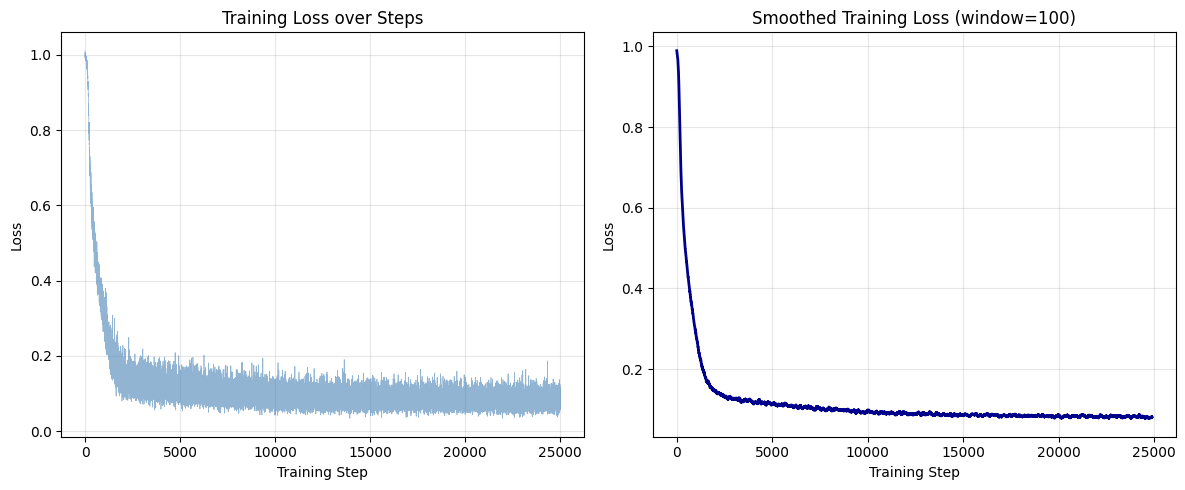


Total steps: 25000
Initial loss: 1.0111
Final loss: 0.0773
Min loss: 0.0338


In [42]:
# Plot the train_logs from PyTorch Lightning CSV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob

# 寻找最新的metrics.csv文件
csv_files = glob.glob('lightning_logs/*/metrics.csv')

if csv_files:
    # 使用最新的version
    latest_csv = sorted(csv_files)[-1]
    print(f"📊 Loading metrics from: {latest_csv}")
    
    # 读取CSV
    df = pd.read_csv(latest_csv)
    print(f"✓ Loaded {len(df)} training steps")
    print(f"Columns: {df.columns.tolist()}")
    
    # 显示数据概览
    print(f"\nTraining summary:")
    print(f"  Total epochs: {df['epoch'].max() + 1}")
    print(f"  Total steps: {df['step'].max() + 1}")
    if 'train_loss' in df.columns:
        df_loss = df.dropna(subset=['train_loss'])
        print(f"  Initial loss: {df_loss['train_loss'].iloc[0]:.4f}")
        print(f"  Final loss: {df_loss['train_loss'].iloc[-1]:.4f}")
        print(f"  Min loss: {df_loss['train_loss'].min():.4f}")
        print(f"  Mean loss: {df_loss['train_loss'].mean():.4f}")
    
    # 绘制训练曲线
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Loss over steps (raw)
    if 'train_loss' in df.columns:
        df_loss = df.dropna(subset=['train_loss'])
        axes[0].plot(df_loss['step'], df_loss['train_loss'], alpha=0.6, linewidth=0.8, color='steelblue')
        axes[0].set_xlabel('Training Step', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].set_title('Training Loss over Steps (Raw)', fontsize=14, fontweight='bold')
        axes[0].grid(True, alpha=0.3, linestyle='--')
        axes[0].set_ylim(bottom=0)
    
    # Plot 2: Loss over epochs (smoothed by epoch mean)
    if 'train_loss' in df.columns and 'epoch' in df.columns:
        df_loss = df.dropna(subset=['train_loss'])
        epoch_loss = df_loss.groupby('epoch')['train_loss'].agg(['mean', 'min', 'max']).reset_index()
        
        axes[1].plot(epoch_loss['epoch'], epoch_loss['mean'], 
                    linewidth=2.5, color='darkblue', label='Mean loss', marker='o', markersize=4)
        axes[1].fill_between(epoch_loss['epoch'], 
                            epoch_loss['min'], 
                            epoch_loss['max'], 
                            alpha=0.2, color='steelblue', label='Min-Max range')
        
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Loss', fontsize=12)
        axes[1].set_title('Training Loss over Epochs (Smoothed)', fontsize=14, fontweight='bold')
        axes[1].legend(loc='upper right', fontsize=10)
        axes[1].grid(True, alpha=0.3, linestyle='--')
        axes[1].set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.savefig('training_loss_from_csv.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Plot saved to: training_loss_from_csv.png")
    plt.show()
    
    # 如果有多个版本，显示所有版本
    if len(csv_files) > 1:
        print(f"\n📝 Note: Found {len(csv_files)} training runs:")
        for csv_file in sorted(csv_files):
            df_temp = pd.read_csv(csv_file)
            print(f"  - {csv_file}: {len(df_temp)} steps, {df_temp['epoch'].max()+1} epochs")

else:
    print("❌ No metrics.csv found in lightning_logs/")
    print("Please check if PyTorch Lightning has created the logs directory.")
    
    # 尝试从model.train_loss读取（如果model在内存中）
    if 'model' in dir() and hasattr(model, 'train_loss') and len(model.train_loss) > 0:
        print("\n📊 Found training loss in model.train_loss, plotting...")
        
        plt.figure(figsize=(12, 5))
        
        # Plot 1: Raw loss
        plt.subplot(1, 2, 1)
        plt.plot(model.train_loss, alpha=0.6, linewidth=0.5, color='steelblue')
        plt.title('Training Loss over Steps')
        plt.xlabel('Training Step')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Smoothed loss
        plt.subplot(1, 2, 2)
        window_size = min(100, len(model.train_loss) // 10)
        if window_size > 1:
            smoothed = np.convolve(model.train_loss, np.ones(window_size)/window_size, mode='valid')
            plt.plot(smoothed, linewidth=2, color='darkblue')
            plt.title(f'Smoothed Training Loss (window={window_size})')
        else:
            plt.plot(model.train_loss, linewidth=2, color='darkblue')
            plt.title('Training Loss')
        plt.xlabel('Training Step')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('training_loss_from_memory.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\nTotal steps: {len(model.train_loss)}")
        print(f"Initial loss: {model.train_loss[0]:.4f}")
        print(f"Final loss: {model.train_loss[-1]:.4f}")
        print(f"Min loss: {np.min(model.train_loss):.4f}")
    else:
        print("Also no training loss found in memory.")


### Sample and Evaluate DiT

In addition to implementing the code above, please complete the following:
1. Plot loss over epochs. Show that loss decreases over epochs.
2. Generate new samples using your DiT checkpoint. Show that samples look reasonable.

In [ ]:
# device = (
#     torch.device("mps")
#     if torch.backends.mps.is_available()
#     else torch.device("cuda")
#     if torch.cuda.is_available()
#     else torch.device("cpu")
# )

# model.to(device)
# # later: tensor.to(device) for inputs

In [44]:
device = (
    torch.device("cpu")
    if torch.backends.mps.is_available()
    else torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("cpu")
)

model.to(device)
# later: tensor.to(device) for inputs

DiffusionModel(
  (patch_vae): PatchVAE(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(16, 16), stride=(8, 8))
      (deconv): Sequential(
        (0): ConvTranspose2d(64, 3, kernel_size=(16, 16), stride=(8, 8))
        (1): Tanh()
      )
    )
    (encoder): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
    )
    (conv_mu): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_logvar): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (decoder_input): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (decoder)

In [45]:
import numpy as np
from tqdm import tqdm

# Discard labels and only output data
class MyDataset(Dataset):
    def __init__(self, dataset, fn):
        self.dataset = dataset
        self.fn = fn
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, i):
        return self.fn(self.dataset[i])

# generate 2k images and score in the tensor
total_image = 2000
batch_size = 8
iterations = 2000 // batch_size + 1
model.load_state_dict(torch.load("model.pt"))
model.eval()
# model.cuda()

sampled_images = np.zeros((batch_size * iterations, 3, 32, 32), dtype=np.float32)
for i in tqdm(range(iterations)):
    imgs = model.sample_image(batchsize=batch_size)
    sampled_images[i*batch_size:(i+1)*batch_size] = imgs.detach().cpu().numpy()
sampled_images = sampled_images[:total_image]
mydataset = MyDataset(sampled_images, lambda x: x)

patch_vae_images = np.zeros((batch_size * iterations, 3, 32, 32), dtype=np.float32)
for i in tqdm(range(iterations)):
    imgs = 0.5 + 0.5 * model.patch_vae.sample(batch_size)
    patch_vae_images[i*batch_size:(i+1)*batch_size] = imgs.detach().cpu().numpy()
patch_vae_images = patch_vae_images[:total_image]
patch_vae_dataset = MyDataset(patch_vae_images, lambda x: x)

celebdataset = dataset = Subset(valid_dataloader.dataset, torch.arange(2000))  # Limit dataset size

100%|██████████| 251/251 [00:00<00:00, 1168.99it/s]


3. Compute FID between images in CelebA dataset and:
    i. Images generated from PatchVAE.
    ii. Images generated from Diffusion

In [46]:
!pip install pytorch-fid scipy==1.11.1

  Using cached scipy-1.11.1.tar.gz (56.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [43 lines of output]
      + meson setup /private/var/folders/10/1lxt8x6s2m378070kn3j5psw0000gp/T/pip-install-kxy6342z/scipy_a85266118c8445ee8d3defbc416870a4 /private/var/folders/10/1lxt8x6s2m378070kn3j5psw0000gp/T/pip-install-kxy6342z/scipy_a85266118c8445ee8d3defbc416870a4/.mesonpy-h_xbqc9t/build -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=/private/var/folders/10/1lxt8x6s2m378070kn3j5psw0000gp/T/pip-install-kxy6342z/scipy_a85266118c8445ee8d3defbc416870a4/.mesonpy-h_xbqc9t/build/meson-python-native-file.ini
      The Meson build system
      Version: 1.9.1
      Source dir: /private/var/folders/10/1lxt8x6s2m378070

In [50]:
!pip install urllib3


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
# ! pip install pytorch-fid scipy==1.11.1

# Fix SSL certificate verification issue
import os
import ssl
import certifi
import urllib.request
import urllib.error

# Set environment variable for SSL certificates (most reliable method)
certifi_cert_path = certifi.where()
os.environ['SSL_CERT_FILE'] = certifi_cert_path
os.environ['REQUESTS_CA_BUNDLE'] = certifi_cert_path

# Create SSL context using certifi's certificate bundle
ssl_context = ssl.create_default_context(cafile=certifi_cert_path)

# Patch the default SSL context creation function
original_create_default_context = ssl.create_default_context
def create_default_context_with_certifi(*args, **kwargs):
    if 'cafile' not in kwargs:
        kwargs['cafile'] = certifi_cert_path
    return original_create_default_context(*args, **kwargs)
ssl.create_default_context = create_default_context_with_certifi

# Patch HTTPSHandler to use certifi certificates
original_https_handler_init = urllib.request.HTTPSHandler.__init__
def https_handler_init_with_certifi(self, debuglevel=0, context=None, check_hostname=None):
    if context is None:
        context = ssl.create_default_context(cafile=certifi_cert_path)
    return original_https_handler_init(self, debuglevel=debuglevel, context=context, check_hostname=check_hostname)
urllib.request.HTTPSHandler.__init__ = https_handler_init_with_certifi

# Patch urlopen to use certifi certificates
original_urlopen = urllib.request.urlopen
def urlopen_with_certifi(*args, **kwargs):
    if 'context' not in kwargs:
        kwargs['context'] = ssl_context
    return original_urlopen(*args, **kwargs)
urllib.request.urlopen = urlopen_with_certifi

print("SSL certificate verification fixed using certifi")

from pytorch_fid.inception import InceptionV3
import scipy.linalg as linalg

def build_feature_table(dataset, model, batch_size, dim, device):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm(enumerate(dataloader, 0)):
        # Handle both single tensor and (image, label) tuple
        if isinstance(data, (list, tuple)):
            image = data[0].to(device)
        else:
            image = data.to(device)

        with torch.no_grad():
            pred = model(image)[0]
            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)

    return feature_table

def compute_stat(feature_table):
    '''
    Argms:
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        mu: mean along row dimension
        sigma: covarance matrix of dataset
    '''
    # compute mean and sigma based on activation table
    mu = np.mean(feature_table, axis=0)
    sigma = np.cov(feature_table, rowvar=False)

    return mu, sigma

def compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6):
    '''
    Argms:
    Input:
        mu_1: mean vector we get for dataset1
        sigma_1: covariance matrix for dataset1
        mu_2: mean vector we get for dataset2
        sigma_2: covariance matrix for dataset1
    Output:
        FID score: float
    '''

    # compute mu difference

    # compute square root of Sigma1*Sigma2 using "linalg.sqrtm" from scipy
    # please name the resulting matrix as covmean

    ######### BEGIN TODO ########
    # Compute mean difference squared
    diff = mu_1 - mu_2
    
    # Compute square root of Sigma1*Sigma2
    from scipy import linalg
    covmean = linalg.sqrtm(sigma_1.dot(sigma_2))
    ######## END TODO ########


    # The following block take care of imagionary part of covmean
    #################################################################
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma_1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma_1 + offset).dot(sigma_2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    #################################################################

    ######### BEGIN TODO ########
    # Compute FID: ||mu_1 - mu_2||^2 + Tr(sigma_1 + sigma_2 - 2*covmean)
    tr_covmean = np.trace(covmean)
    FID = diff.dot(diff) + np.trace(sigma_1) + np.trace(sigma_2) - 2 * tr_covmean
    ######## END TODO ########



    return FID

def FID(dataset_1, dataset_2, device, batch_size=64, dim=2048, block_idx = 3):
    '''
    Argms:
    Input:
        dataset_1: pytorch dataset
        dataset_2: pytorch dataset
        device: device type torch.device("cuda:0") or torch.device("cpu")
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        block_idx: the block stage index we want to use in inception module
    Output:
        FID_score: float
    '''
    # load InveptionV3 model
    model = InceptionV3([block_idx]).to(device)

    ## build up the feature table
    feature_table_1 = build_feature_table(dataset_1, model, batch_size, dim, device)
    feature_table_2 = build_feature_table(dataset_2, model, batch_size, dim, device)


    ## compute mu, sigma for dataset 1&2
    mu_1, sigma_1 = compute_stat(feature_table_1)
    mu_2, sigma_2 = compute_stat(feature_table_2)

    ## FID score computation
    FID_score = compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6)

    return FID_score

# device = torch.device("cuda:0") 
device = torch.device("cpu") 
FID_score = FID(celebdataset, celebdataset, device)
print('FID_score between CelebA and itself:', FID_score)

FID_score = FID(celebdataset, mydataset, device)
print('FID_score between CelebA and images sampled from Diffusion Model:', FID_score)

FID_score = FID(celebdataset, patch_vae_dataset, device)
print('FID_score between CelebA and images sampled from PatchVAE:', FID_score)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /Users/kyle/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>